In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [3]:
df=pd.read_csv('24-hours dataset.csv')

In [5]:
df

,Unnamed: 0,timestamp,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation,load
0,0,2023-01-01 00:00:00,6,0,1,17.483571,0,7.819507,18493
1,1,2023-01-01 01:00:00,6,1,1,14.308678,0,0.886376,17090
2,2,2023-01-01 02:00:00,6,2,1,18.238443,0,0.798470,16052
3,3,2023-01-01 03:00:00,6,3,1,22.615149,0,3.067700,15356
4,4,2023-01-01 04:00:00,6,4,1,13.829233,0,0.359479,14936
...,...,...,...,...,...,...,...,...,...
8732,8732,2023-12-30 20:00:00,5,20,1,16.464144,0,7.909442,23111
8733,8733,2023-12-30 21:00:00,5,21,1,5.597822,0,3.319968,22308
8734,8734,2023-12-30 22:00:00,5,22,1,7.153052,0,9.686246,21935
8735,8735,2023-12-30 23:00:00,5,23,1,11.815588,0,0.498725,20497


In [6]:
def assign_compensation_method(row):
    if row['is_holiday'] == 1:
        return 'Lower Power Supply'
    elif row['solar_generation'] > 200:
        return 'Increased Renewable Energy Integration'
    elif row['hour_of_day'] >= 18 and row['hour_of_day'] <= 22:
        return 'Peak Load Shifting'
    elif row['temperature'] > 35:
        return 'Increased Power Supply'
    else:
        return 'Normal Operation'

df['compensation_method'] = df.apply(assign_compensation_method, axis=1)

print(df[['timestamp', 'load', 'compensation_method']].head(10))


             timestamp   load                     compensation_method
0  2023-01-01 00:00:00  18493                        Normal Operation
1  2023-01-01 01:00:00  17090                        Normal Operation
2  2023-01-01 02:00:00  16052                        Normal Operation
3  2023-01-01 03:00:00  15356                        Normal Operation
4  2023-01-01 04:00:00  14936                        Normal Operation
5  2023-01-01 05:00:00  14884                        Normal Operation
6  2023-01-01 06:00:00  15314  Increased Renewable Energy Integration
7  2023-01-01 07:00:00  16591  Increased Renewable Energy Integration
8  2023-01-01 08:00:00  18271                        Normal Operation
9  2023-01-01 09:00:00  19470  Increased Renewable Energy Integration


In [21]:
# Features and target for classification
X_class = df[['temperature', 'solar_generation', 'hour_of_day', 'is_holiday', 'load']]
y_class = df['compensation_method']

# Splitting data into training and testing sets (80% train, 20% test)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# OneHotEncoding the target labels (compensation_method) for multi-class classification
encoder = OneHotEncoder(sparse_output=False)
y_train_class_encoded = encoder.fit_transform(y_train_class.values.reshape(-1, 1))
y_test_class_encoded = encoder.transform(y_test_class.values.reshape(-1, 1))

# Scaling the features
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)


In [12]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [14]:
# ANN model for classification
model_class = Sequential()

# Adding layers
model_class.add(Dense(128, input_dim=X_train_class_scaled.shape[1], activation='relu'))
model_class.add(Dense(64, activation='relu'))
model_class.add(Dense(32, activation='relu'))
model_class.add(Dense(5, activation='softmax'))  # Assuming 3 compensation methods

# Compile the model
model_class.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_class = model_class.fit(X_train_class_scaled, y_train_class_encoded, epochs=25, batch_size=32, validation_data=(X_test_class_scaled, y_test_class_encoded))


Epoch 1/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7088 - loss: 0.8810 - val_accuracy: 0.9010 - val_loss: 0.2676
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9044 - loss: 0.2600 - val_accuracy: 0.9302 - val_loss: 0.1996
Epoch 3/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9170 - loss: 0.2181 - val_accuracy: 0.9342 - val_loss: 0.1790
Epoch 4/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9262 - loss: 0.1818 - val_accuracy: 0.9405 - val_loss: 0.1595
Epoch 5/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9345 - loss: 0.1645 - val_accuracy: 0.9571 - val_loss: 0.1198
Epoch 6/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9451 - loss: 0.1333 - val_accuracy: 0.9697 - val_loss: 0.0938
Epoch 7/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9612 - loss: 0.1079 - val_accuracy: 0.9668 - val_loss: 0.0880
Epoch 8/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9716 - loss: 0.0906 - val_accuracy: 0.

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Accuracy: 99.37%


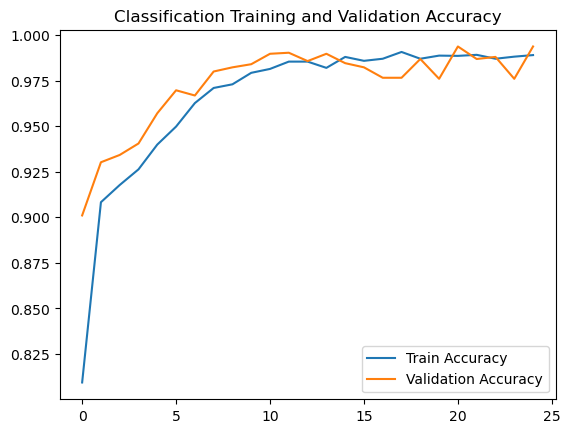

In [15]:
# Predicting on test data
y_pred_class_prob = model_class.predict(X_test_class_scaled)
y_pred_class = np.argmax(y_pred_class_prob, axis=1)

# Converting encoded test labels back to original format for comparison
y_test_class_original = np.argmax(y_test_class_encoded, axis=1)

# Calculate accuracy
classification_accuracy = accuracy_score(y_test_class_original, y_pred_class)
print(f"Classification Accuracy: {classification_accuracy * 100:.2f}%")

# Plotting the accuracy curve
plt.plot(history_class.history['accuracy'], label='Train Accuracy')
plt.plot(history_class.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Training and Validation Accuracy')
plt.legend()
plt.show()


In [23]:
# LSTM model for regression
model = Sequential()

# Adding first LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))

# Adding second LSTM layer
model.add(LSTM(units=64, return_sequences=False))

# Adding output layer for regression (since it's a single value prediction, we use 1 unit)
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,569 (459.25 KB)

 Trainable params: 117,569 (459.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 338174656.0000 - val_loss: 337608224.0000
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 335318976.0000 - val_loss: 337137568.0000
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 333891520.0000 - val_loss: 336711264.0000
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 337397920.0000 - val_loss: 336299648.0000
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 335908128.0000 - val_loss: 335894752.0000
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 333091616.0000 - val_loss: 335494336.0000
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 330653472.0000 - val_loss: 335096544.0000
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 334240768.0000 - val_loss: 334701056.0000
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 333570656.0000 - val_loss: 334306720.0000
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 331506880.0000 - val_

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE: 18166.44


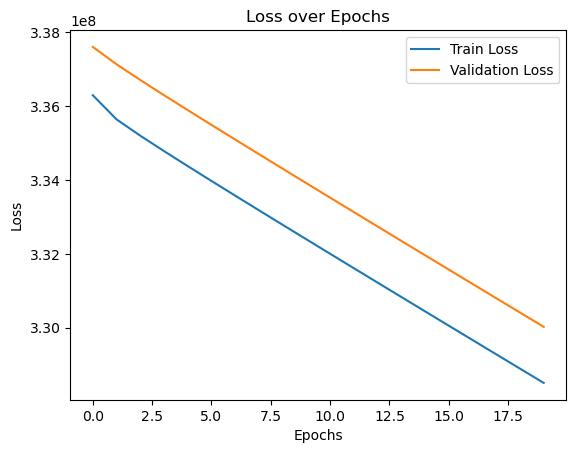

In [25]:
# Predicting on the test data
y_pred = model.predict(X_test_scaled)

# Calculate RMSE (Root Mean Squared Error)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# Plotting the loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


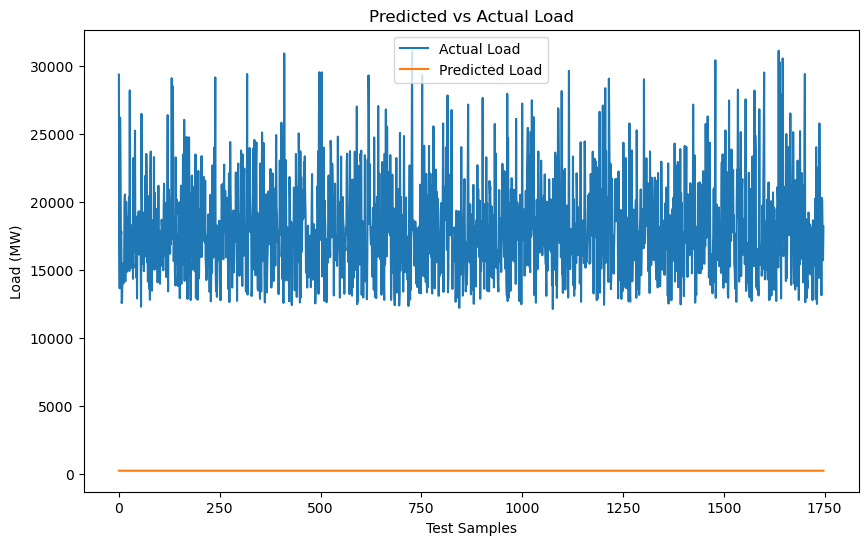

In [26]:
# Plotting the predicted vs actual values for load
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test)), y_test, label='Actual Load')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Load')
plt.title('Predicted vs Actual Load')
plt.xlabel('Test Samples')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()


In [17]:
# ANN model for regression
model_reg = Sequential()

# Adding layers
model_reg.add(Dense(128, input_dim=X_train_reg_scaled.shape[1], activation='relu'))
model_reg.add(Dense(64, activation='relu'))
model_reg.add(Dense(32, activation='relu'))
model_reg.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model_reg.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history_reg = model_reg.fit(X_train_reg_scaled, y_train_reg, epochs=25, batch_size=32, validation_data=(X_test_reg_scaled, y_test_reg))


Epoch 1/25


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 333218400.0000 - mean_squared_error: 333218400.0000 - val_loss: 219666368.0000 - val_mean_squared_error: 219666368.0000
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 115016016.0000 - mean_squared_error: 115016016.0000 - val_loss: 10581474.0000 - val_mean_squared_error: 10581474.0000
Epoch 3/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10055327.0000 - mean_squared_error: 10055327.0000 - val_loss: 9332806.0000 - val_mean_squared_error: 9332806.0000
Epoch 4/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8913372.0000 - mean_squared_error: 8913372.0000 - val_loss: 8443009.0000 - val_mean_squared_error: 8443009.0000
Epoch 5/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7928472.5000 - mean_squared_error: 7928472.5000 - val_loss: 7711015.0000 - val_mean_squared_error: 7711015.0000
Epoch 6/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7513676.0000 - mean_squared_error: 7513676.0000 - val_loss: 7295277.5000 - 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Regression RMSE: 2526.88 MW


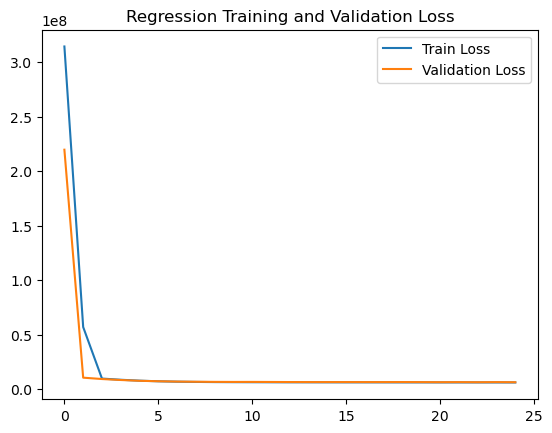

In [18]:
# Predicting on test data
y_pred_reg = model_reg.predict(X_test_reg_scaled)

# Calculate RMSE for regression
regression_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"Regression RMSE: {regression_rmse:.2f} MW")

# Plotting the loss curve for regression
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Regression Training and Validation Loss')
plt.legend()
plt.show()
